In [1]:
import numpy as np
import h5py
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Read the HP5 file
hf = h5py.File('/content/drive/MyDrive/Colab Notebooks/vel3_cutout_rnn.h5', 'r')

In [3]:
a = len(list(hf.keys())) - 3

In [4]:
def readsave(arg1,arg2):
  n1 = np.array(arg1[arg2][:])
  return n1

In [5]:
n = np.array([])
for i in range(a):
  n1 = readsave(hf,list(hf.keys())[i])
  n1 = n1.swapaxes(0,2)
  n1 = n1[0,:,:,0].reshape(n1.shape[0]**2)
  n1 = n1[:,np.newaxis]
  if i == 0:
    n = n1
  else:
    n = np.append(n,n1,axis=1)
    #print(n.shape)

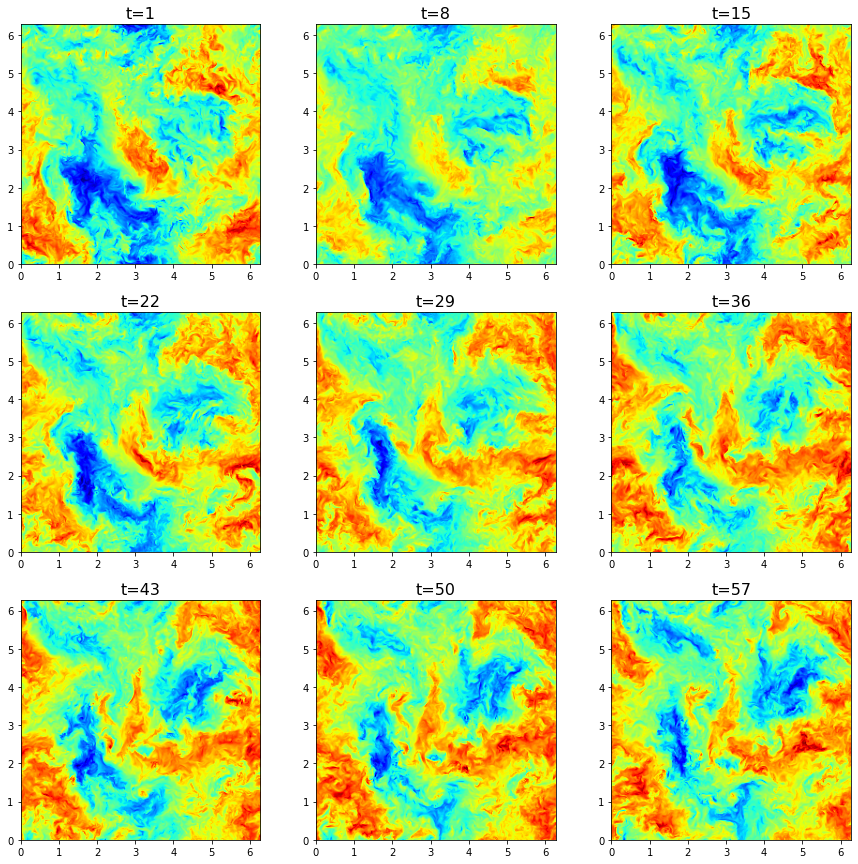

In [6]:
#Plot time evolution of ux along the y-z axis
%matplotlib inline
import matplotlib.pyplot as plt

a = int(n.shape[0]**(1/2))
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(0,63,7):
  count+=1
  b = fig.add_subplot('33' + str(count))
  b.imshow(n[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('t=' + str(i+1),fontsize=16)

In [7]:
#Setup Input and Output that is separated by one step
nn_input = n[:,0:-1].transpose()
nn_output = n[:,1:].transpose()
print(nn_input.shape,nn_output.shape)

In [41]:
#Train NN to model this one timestep
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

# Build model
deep_approx = keras.models.Sequential()
deep_approx.add(layers.Dense(1000, input_dim=nn_input.shape[1], activation='sigmoid'))
deep_approx.add(layers.Dense(2000, activation='relu'))
deep_approx.add(layers.Dense(5000, activation='relu'))
deep_approx.add(layers.Dense(nn_output.shape[1], activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
History = deep_approx.fit(nn_input, nn_output, epochs=500)

Epoch 1/500
2/2 [==============================] - 1s 224ms/step - loss: 0.4213
Epoch 2/500
2/2 [==============================] - 0s 197ms/step - loss: 0.1674
Epoch 3/500
2/2 [==============================] - 0s 195ms/step - loss: 0.1424
Epoch 4/500
2/2 [==============================] - 0s 191ms/step - loss: 0.1376
Epoch 5/500
2/2 [==============================] - 0s 188ms/step - loss: 0.1285
Epoch 6/500
2/2 [==============================] - 0s 192ms/step - loss: 0.1304
Epoch 7/500
2/2 [==============================] - 0s 191ms/step - loss: 0.1297
Epoch 8/500
2/2 [==============================] - 0s 194ms/step - loss: 0.1272
Epoch 9/500
2/2 [==============================] - 0s 192ms/step - loss: 0.1272
Epoch 10/500
2/2 [==============================] - 0s 194ms/step - loss: 0.1253
Epoch 11/500
2/2 [==============================] - 0s 192ms/step - loss: 0.1228
Epoch 12/500
2/2 [==============================] - 0s 191ms/step - loss: 0.1216
Epoch 13/500
2/2 [===================

In [42]:
#Attempt reconstructing time trajectory
start = nn_input[0,:][np.newaxis,:]
t = nn_input.shape[0]
nn_pred = start

for i in range(t):
  nn_pred = np.append(nn_pred,deep_approx.predict(nn_pred[i,:][np.newaxis,:]),axis=0)

nn_pred = nn_pred.transpose()

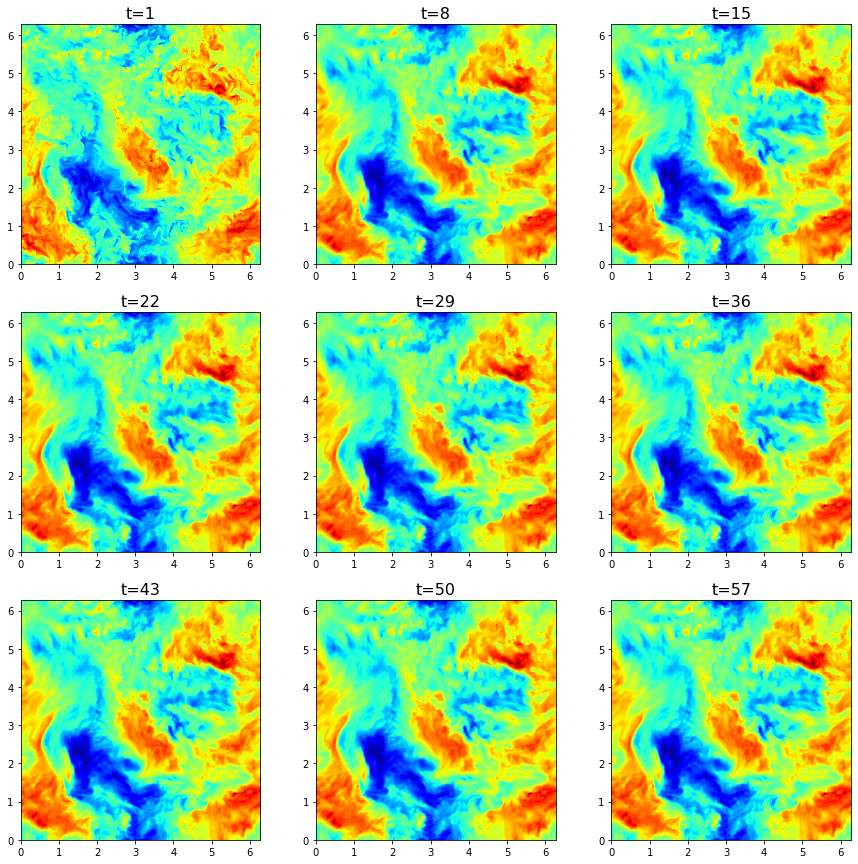

In [43]:
#Plot time evolution of ux along the y-z axis
%matplotlib inline
import matplotlib.pyplot as plt

a = int(n.shape[0]**(1/2))
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(0,63,7):
  count+=1
  b = fig.add_subplot('33' + str(count))
  b.imshow(nn_pred[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('t=' + str(i+1),fontsize=16)

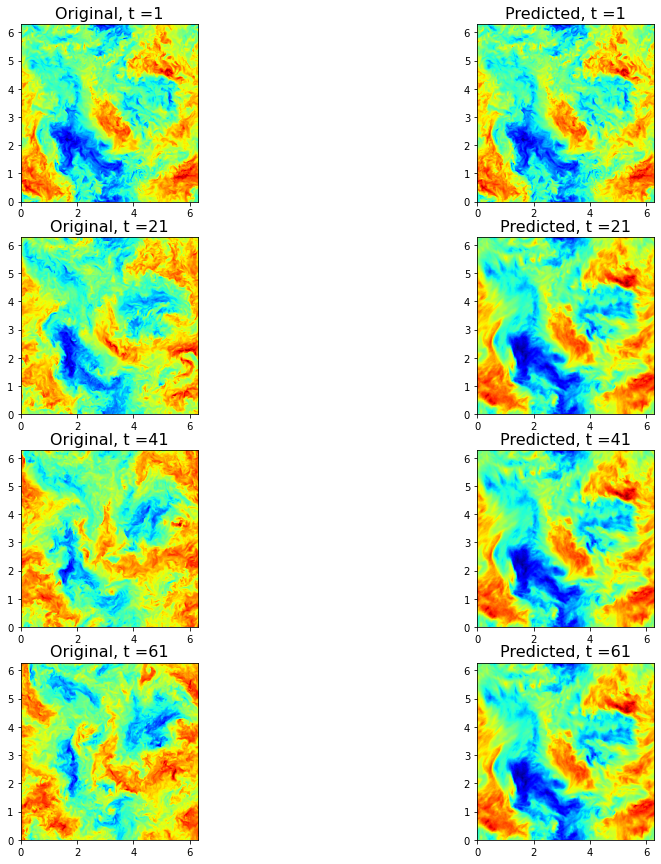

In [44]:
#Compare Actuals vs predicted
a = int(n.shape[0]**(1/2))
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(0,63,20):
  count+=1
  b = fig.add_subplot('42' + str(count))
  b.imshow(n[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('Original, t =' + str(i+1),fontsize=16)
  
  count+=1
  b = fig.add_subplot('42' + str(count))
  b.imshow(nn_pred[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('Predicted, t =' + str(i+1),fontsize=16)